The peak absolute magnitude is: -19.5


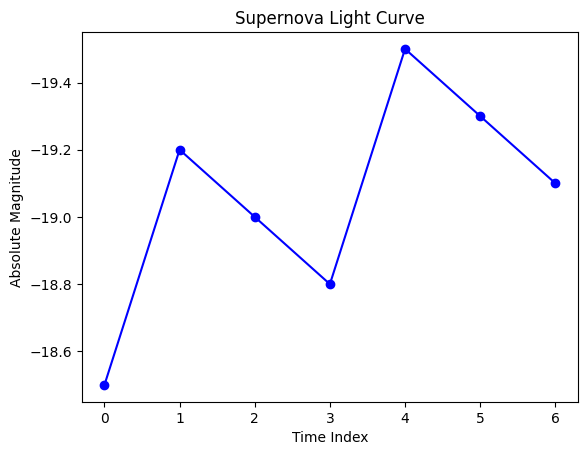

In [1]:
import numpy as np

# Assuming `absolute_magnitudes` is your array of absolute magnitude values
absolute_magnitudes = np.array([-18.5, -19.2, -19.0, -18.8, -19.5, -19.3, -19.1])

# Find the peak absolute magnitude
peak_absolute_magnitude = np.min(absolute_magnitudes)

print(f"The peak absolute magnitude is: {peak_absolute_magnitude}")

import matplotlib.pyplot as plt

# Plot the light curve (optional)
plt.plot(absolute_magnitudes, marker='o', linestyle='-', color='b')
plt.gca().invert_yaxis()  # Invert y-axis because magnitudes are brighter for lower values
plt.xlabel('Time Index')
plt.ylabel('Absolute Magnitude')
plt.title('Supernova Light Curve')
plt.show()


In [ ]:
import io
import re
import sys
import time

import pandas as pd
import requests

BASEURL = "https://fallingstar-data.com/forcedphot"

resp = requests.post(url=f"{BASEURL}/api-token-auth/", data={'username': "__my_username__", 'password': "__my_password__"})

if resp.status_code == 200:
    token = resp.json()['token']
    print(f'Your token is {token}')
    headers = {'Authorization': f'Token {token}', 'Accept': 'application/json'}
else:
    print(f'ERROR {resp.status_code}')
    print(resp.json())

task_url = None
while not task_url:
    with requests.Session() as s:
        resp = s.post(f"{BASEURL}/queue/", headers=headers, data={
            'ra': 44, 'dec': 22, 'mjd_min': 59248.})

        if resp.status_code == 201:  # successfully queued
            task_url = resp.json()['url']
            print(f'The task URL is {task_url}')
        elif resp.status_code == 429:  # throttled
            message = resp.json()["detail"]
            print(f'{resp.status_code} {message}')
            t_sec = re.findall(r'available in (\d+) seconds', message)
            t_min = re.findall(r'available in (\d+) minutes', message)
            if t_sec:
                waittime = int(t_sec[0])
            elif t_min:
                waittime = int(t_min[0]) * 60
            else:
                waittime = 10
            print(f'Waiting {waittime} seconds')
            time.sleep(waittime)
        else:
            print(f'ERROR {resp.status_code}')
            print(resp.json())
            sys.exit()

result_url = None
while not result_url:
    with requests.Session() as s:
        resp = s.get(task_url, headers=headers)

        if resp.status_code == 200:  # HTTP OK
            if resp.json()['finishtimestamp']:
                result_url = resp.json()['result_url']
                print(f"Task is complete with results available at {result_url}")
                break
            elif resp.json()['starttimestamp']:
                print(f"Task is running (started at {resp.json()['starttimestamp']})")
            else:
                print("Waiting for job to start. Checking again in 10 seconds...")
            time.sleep(10)
        else:
            print(f'ERROR {resp.status_code}')
            print(resp.json())
            sys.exit()

with requests.Session() as s:
    textdata = s.get(result_url, headers=headers).text

    # if we'll be making a lot of requests, keep the web queue from being
    # cluttered (and reduce server storage usage) by sending a delete operation
    s.delete(task_url, headers=headers).json()
    
dfresult = pd.read_csv(io.StringIO(textdata.replace("###", "")), delim_whitespace=True)
print(dfresult)